In [2]:
%matplotlib notebook

import pickle
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

## Загружаем данные и смотрим их

In [3]:
with open('data.pickle', 'rb') as file:
    data = pickle.load(file)

In [4]:
data

array([(0.00000000e+00, 19.93781954, 0., 0., 0.66666542, 18.04632478,  1.14199163, -0.13816724,  0.11882871, -0.33201249, 101.19626836),
       (4.16670000e-04, 21.42621608, 0., 0., 0.73441245, 18.12961005,  1.00423363, -0.15204705,  0.12019912, -0.33927556, 101.20027166),
       (8.33330000e-04, 21.42621608, 0., 0., 0.89557297, 18.13456483,  0.78969135, -0.163737  ,  0.11335076, -0.35066093, 101.19626836),
       ...,
       (1.99987500e+01, 17.90261273, 0., 0., 1.03127364, 15.82213725, -0.62543498,  0.03959013, -0.06670818, -0.77751398, 100.81587107),
       (1.99991667e+01, 17.90261273, 0., 0., 0.97952484, 15.72617123, -0.91529134,  0.05288883, -0.09143817, -0.77684405, 100.85054683),
       (1.99995833e+01, 34.51683304, 0., 0., 0.9762958 , 15.39210427, -1.26735209,  0.06293221, -0.09527916, -0.77229087, 100.85054683)],
      dtype=[('time', '<f8'), ('alpha', '<f8'), ('beta', '<f8'), ('gamma', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Mx', '<f8'), ('My', '<f8'), ('Mz', '<f

In [5]:
data['time']

array([0.00000000e+00, 4.16670000e-04, 8.33330000e-04, ...,
       1.99987500e+01, 1.99991667e+01, 1.99995833e+01])

<IPython.core.display.Javascript object>


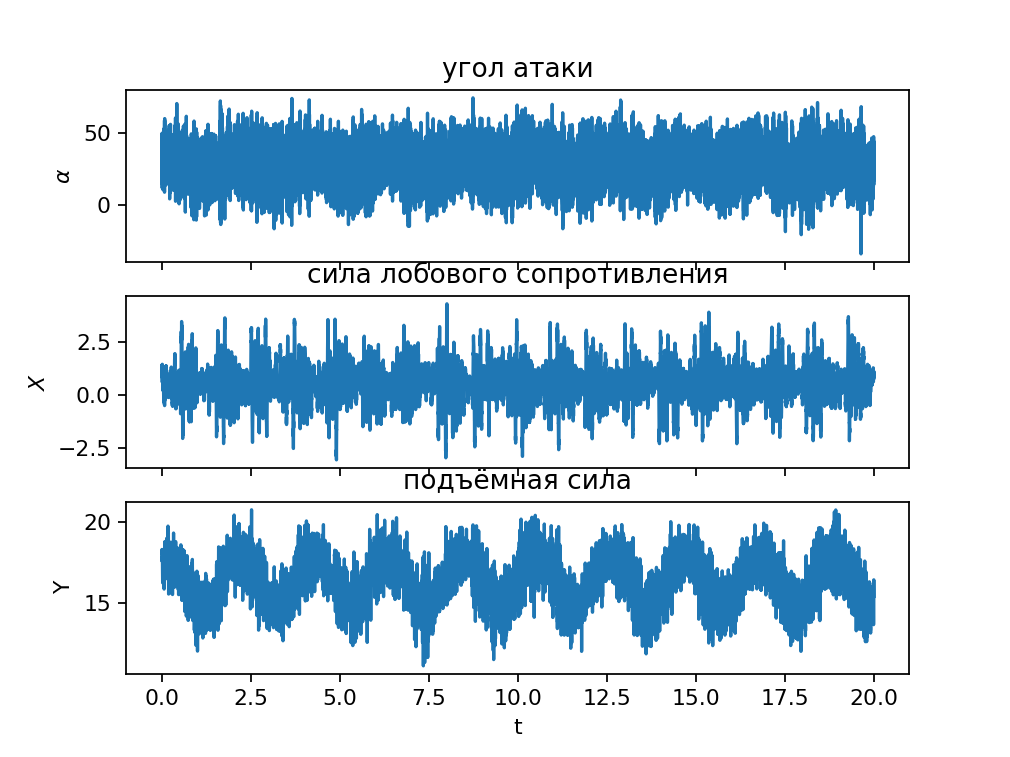

In [6]:
_, (a1, a2, a3) = plt.subplots(nrows=3, sharex=True)
a1.plot(data['time'], data['alpha'])
a2.plot(data['time'], data['X'])
a3.plot(data['time'], data['Y'])
a3.set(xlabel='t', ylabel=r'Y', title='подъёмная сила')
a2.set(ylabel=r'$X$', title='сила лобового сопротивления')
a1.set(ylabel=r'$\alpha$', title='угол атаки')
pass

## Спектральный анализ подъёмной силы

In [7]:
1 / np.mean(np.diff(data['time']))  # 2400 Гц -- частота дискретизации данных

2400.0000004000085

<IPython.core.display.Javascript object>


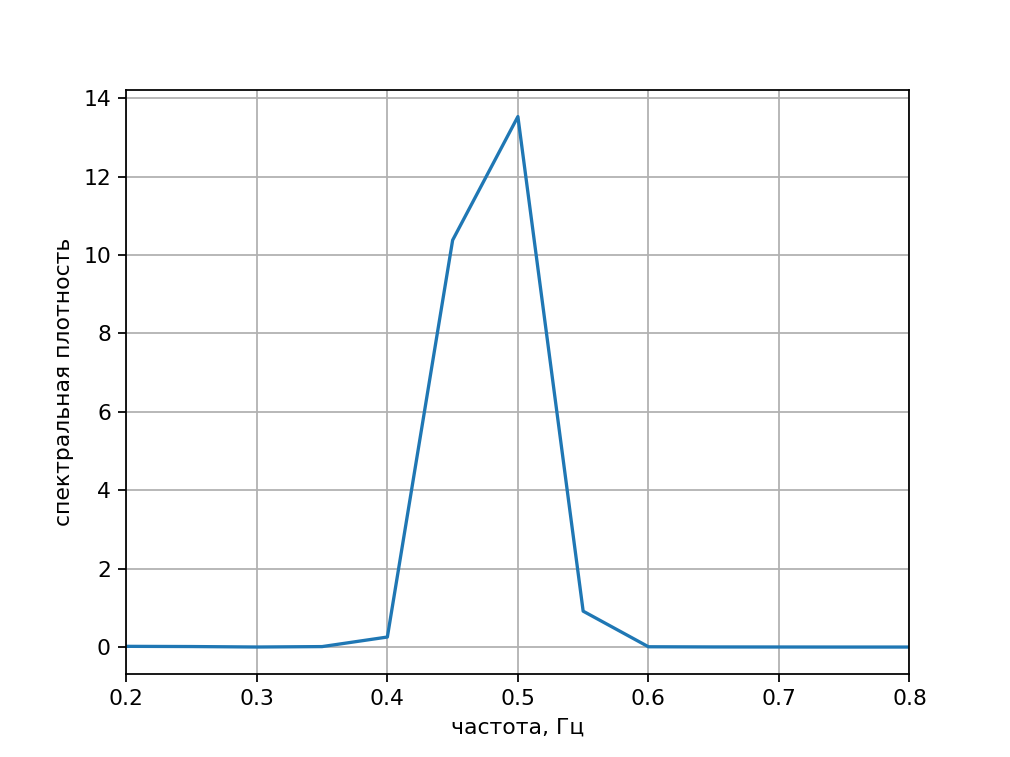

In [8]:
fs, pxx = welch(data['Y'], 2400, nperseg=48000)

plt.figure()
plt.plot(fs, pxx)
plt.xlim([0.2, 0.8])
plt.xlabel('частота, Гц')
plt.ylabel('спектральная плотность')
plt.grid()

## Выделение синусоиды известной частоты наименьшими квадратами

In [9]:
omega = 2 * np.pi * 0.48  # по результатам спектрального анализа
a = np.vstack((np.ones_like(data['time']),
               np.cos(omega * data['time']),
               np.sin(omega * data['time'])))
a = a.T

In [10]:
c, _, _, _ = np.linalg.lstsq(a, data['Y'].reshape((-1, 1)), rcond=None)

<IPython.core.display.Javascript object>


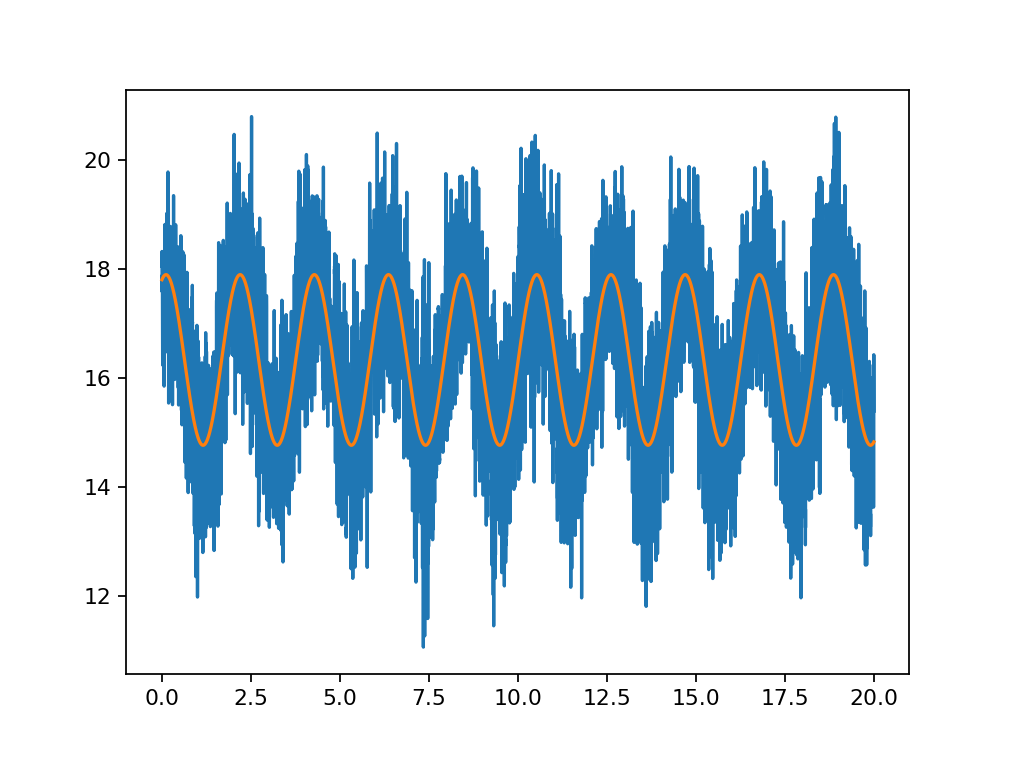

In [11]:
plt.figure()
plt.plot(data['time'], data['Y'])
plt.plot(data['time'], a @ c)
pass

## Подсчёт коэффициентов ряда Фурье наименьшими квадратами

In [14]:
def fourier_filter(time, x, omega, n=1):
    n_omega = np.arange(-n, n + 1).reshape((1, -1)) * omega
    a = np.exp(1j * time.reshape((-1, 1)) @ n_omega)
    
    c, _, _, _ = np.linalg.lstsq(a, x.reshape((-1, 1)), rcond=None)
    return c, np.real(a @ c)

<IPython.core.display.Javascript object>


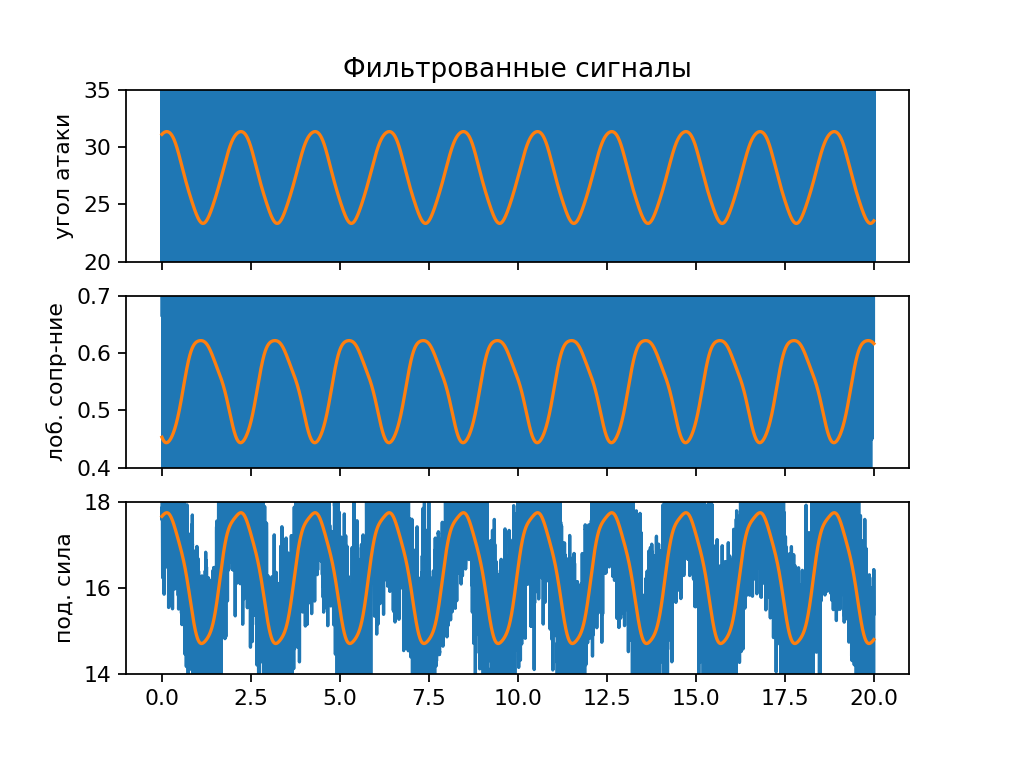

In [15]:
omega = 2 * np.pi * 0.48
n = 4  # выбран по спектральной плотности. шум начинается где-то с 5Гц

_, alpha_filtered = fourier_filter(data['time'], data['alpha'], omega, n=n)
_, x_filtered = fourier_filter(data['time'], data['X'], omega, n=n)
_, y_filtered = fourier_filter(data['time'], data['Y'], omega, n=n)

_, (a1, a2, a3) = plt.subplots(nrows=3, sharex=True)
a1.plot(data['time'], data['alpha'])
a1.set(ylim=[20, 35], title='Фильтрованные сигналы', ylabel='угол атаки')
a1.plot(data['time'], alpha_filtered)
a2.plot(data['time'], data['X'])
a2.plot(data['time'], x_filtered)
a2.set(ylim=[0.4, 0.7], ylabel='лоб. сопр-ние')
a3.plot(data['time'], data['Y'])
a3.plot(data['time'], y_filtered)
a3.set(ylim=[14, 18], ylabel='под. сила')
pass